# Neurons example, pt. 1
## Generate some data

In [1]:
from bayes_window import models, fake_spikes_explore, BayesWindow
from bayes_window.generative_models import generate_fake_spikes
from importlib import reload
import numpy as np
import altair as alt
alt.data_transformers.disable_max_rows()
try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass

In [2]:

df, df_monster, index_cols, firing_rates = generate_fake_spikes(n_trials=20,
                                                                n_neurons=6,
                                                                n_mice=3,
                                                                dur=5,
                                                               mouse_response_slope=40,
                                                               overall_stim_response_strength=5)


## Exploratory plot without any fitting

Three mice, five neurons each. Mouse #0/neuron #4 has the least effect, mouse #2/neuron #0 the most

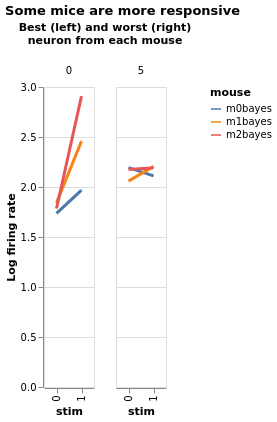

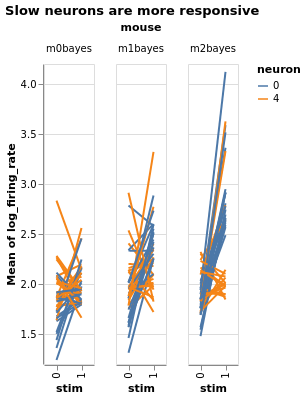

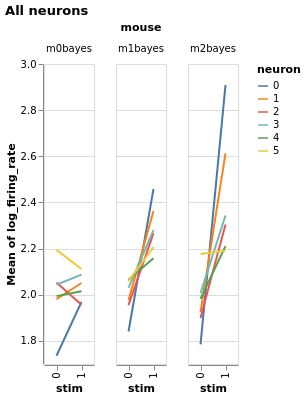

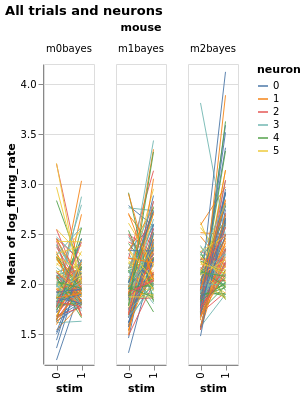

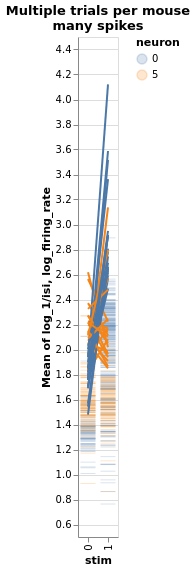

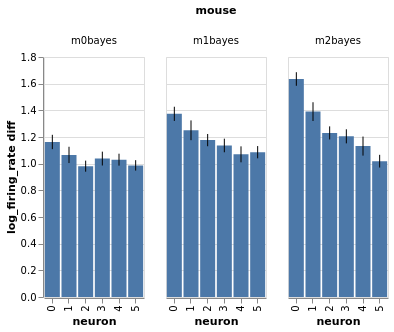

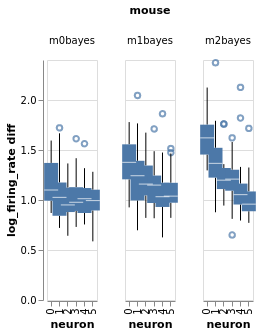

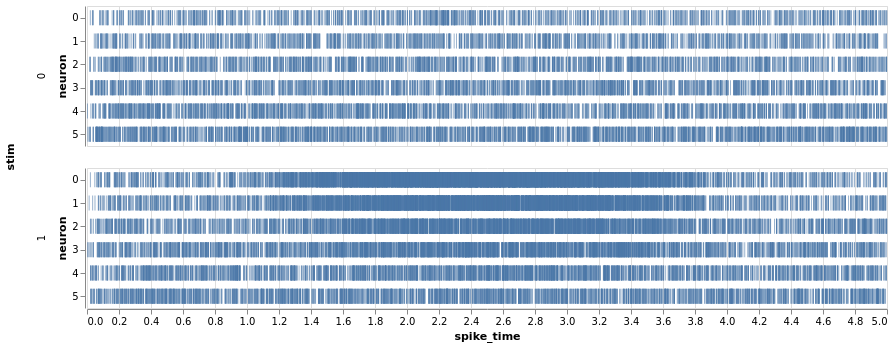

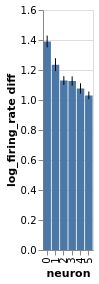

In [3]:

charts=fake_spikes_explore(df,df_monster,index_cols)
[chart.display() for chart in charts];
#fig_mice, fig_select, fig_neurons, fig_trials, fig_isi + fig_overlay, bar, box, fig_raster, bar_combined

## Estimate with neuron as condition

### ISI

In [4]:
df['log_isi']=np.log10(df['isi'])

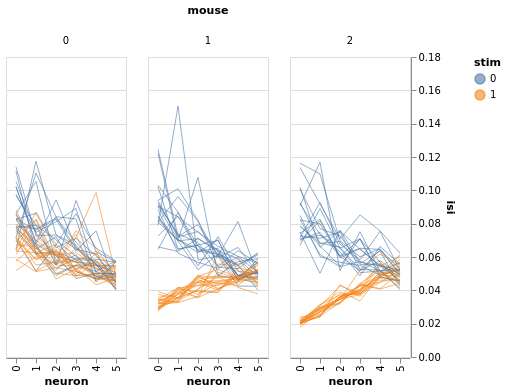

In [5]:
bw = BayesWindow(df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',color='stim',detail='i_trial',add_box=False).facet(column='mouse',)

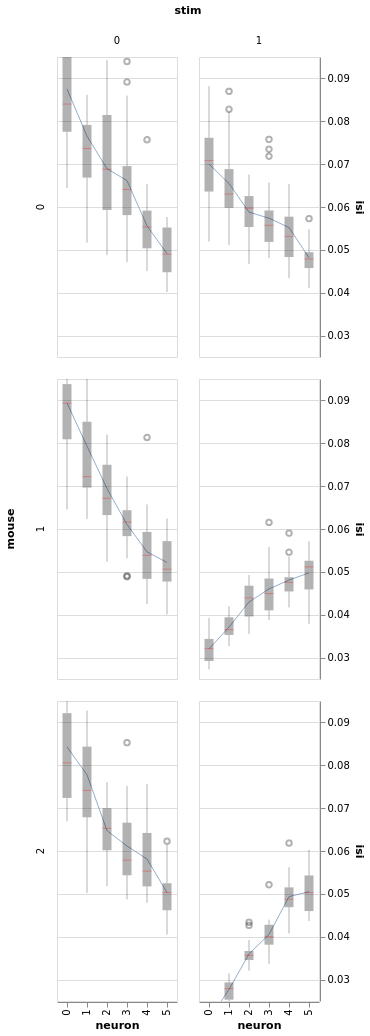

In [6]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.plot(x='neuron',add_box=True).facet(row='mouse',column='stim')

## Vanilla regression

n(Divergences) = 2


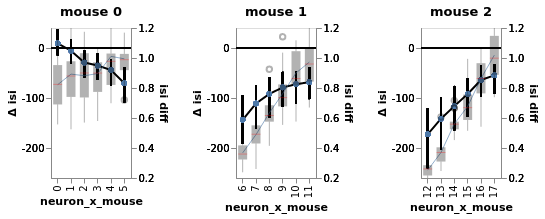

In [7]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse', detail='i_trial')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='divide',
              dist_y='normal',
             )

bw.chart

## GLM
($y\sim Gamma(\theta)$)

n(Divergences) = 4


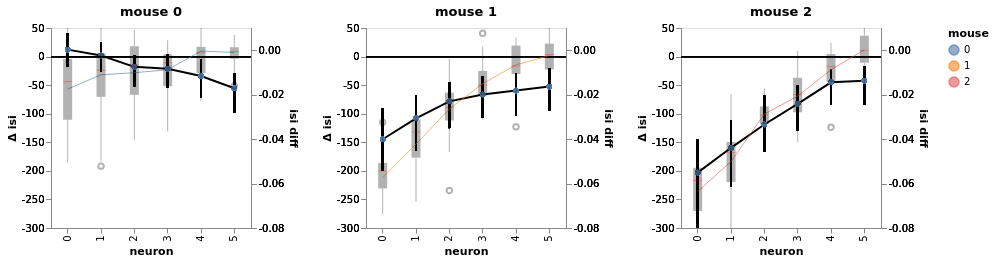

In [26]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse', detail='i_trial')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse','i_trial'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

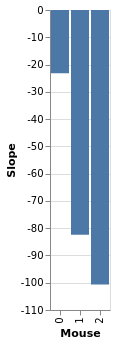

In [9]:
import altair as alt
slopes=bw.trace.posterior['slope_per_group'].mean(['chain','draw']).to_dataframe().reset_index()
chart_slopes=alt.Chart(slopes).mark_bar().encode(
    x=alt.X('mouse_:O',title='Mouse'),
    y=alt.Y('slope_per_group', title='Slope')
)
chart_slopes

In [10]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse',)
#bw.fit_anova()
bw.fit_lme()

Using formula firing_rate ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                              Coef. Std.Err.       z  P>|z|    [0.025   0.975]
Intercept                  -186.613  129.048  -1.446  0.148  -439.543   66.316
1 | mouse                   192.950   67.060   2.877  0.004    61.514  324.385
stim | neuron_x_mouse__0    107.321  160.353   0.669  0.503  -206.965  421.607
stim | neuron_x_mouse__1    163.943  160.353   1.022  0.307  -150.344  478.229
stim | neuron_x_mouse__2    241.525  160.353   1.506  0.132   -72.762  555.811
stim | neuron_x_mouse__3    1

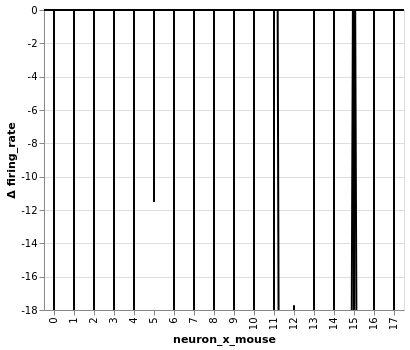

In [11]:
bw.regression_charts(x='neuron_x_mouse:O')

### Firing rate

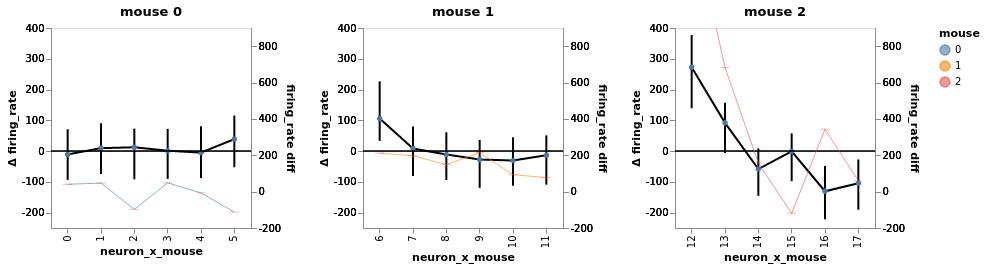

In [12]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')
bw.fit_slopes(model=models.model_hierarchical, do_make_change='subtract',
              progress_bar=False,
              dist_y='student',
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

ANOVA may not be appropriate here: It considers every neuron. If we look hard enough, surely we'll find a responsive neuron or two out of hundreds?

In [13]:
bw = BayesWindow(df, y='firing_rate', treatment='stim', condition='neuron_x_mouse', group='mouse')

bw.fit_anova(formula='firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse');

firing_rate ~ stim+ mouse + stim*mouse + neuron_x_mouse + stim * neuron_x_mouse
                         sum_sq   df       F  PR(>F)
stim                     -0.00  1.0   -0.00    1.00
mouse                  6491.97  1.0    3.07    0.22
stim:mouse             7014.97  1.0    3.32    0.21
neuron_x_mouse       255069.09  1.0  120.81    0.01
stim:neuron_x_mouse   99777.33  1.0   47.26    0.02
Residual               4222.48  2.0     NaN     NaN


## Model quality

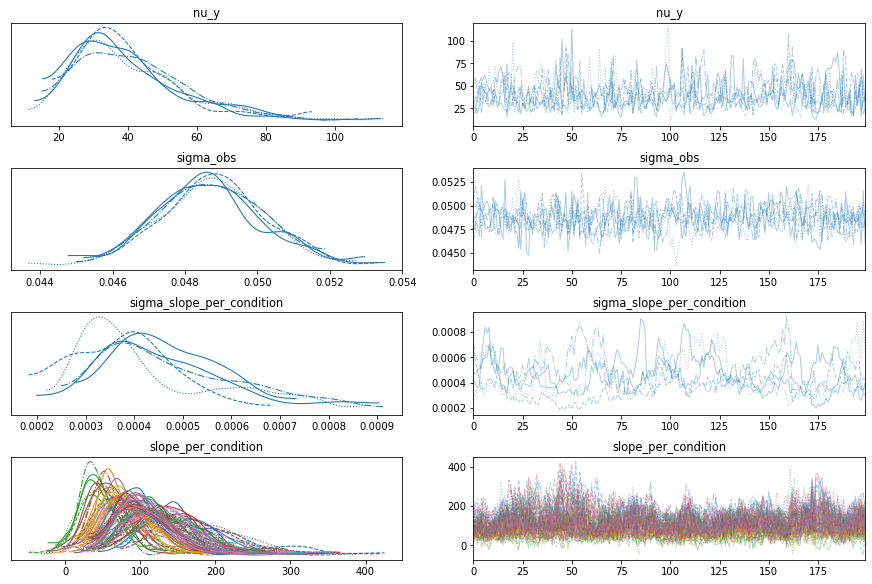

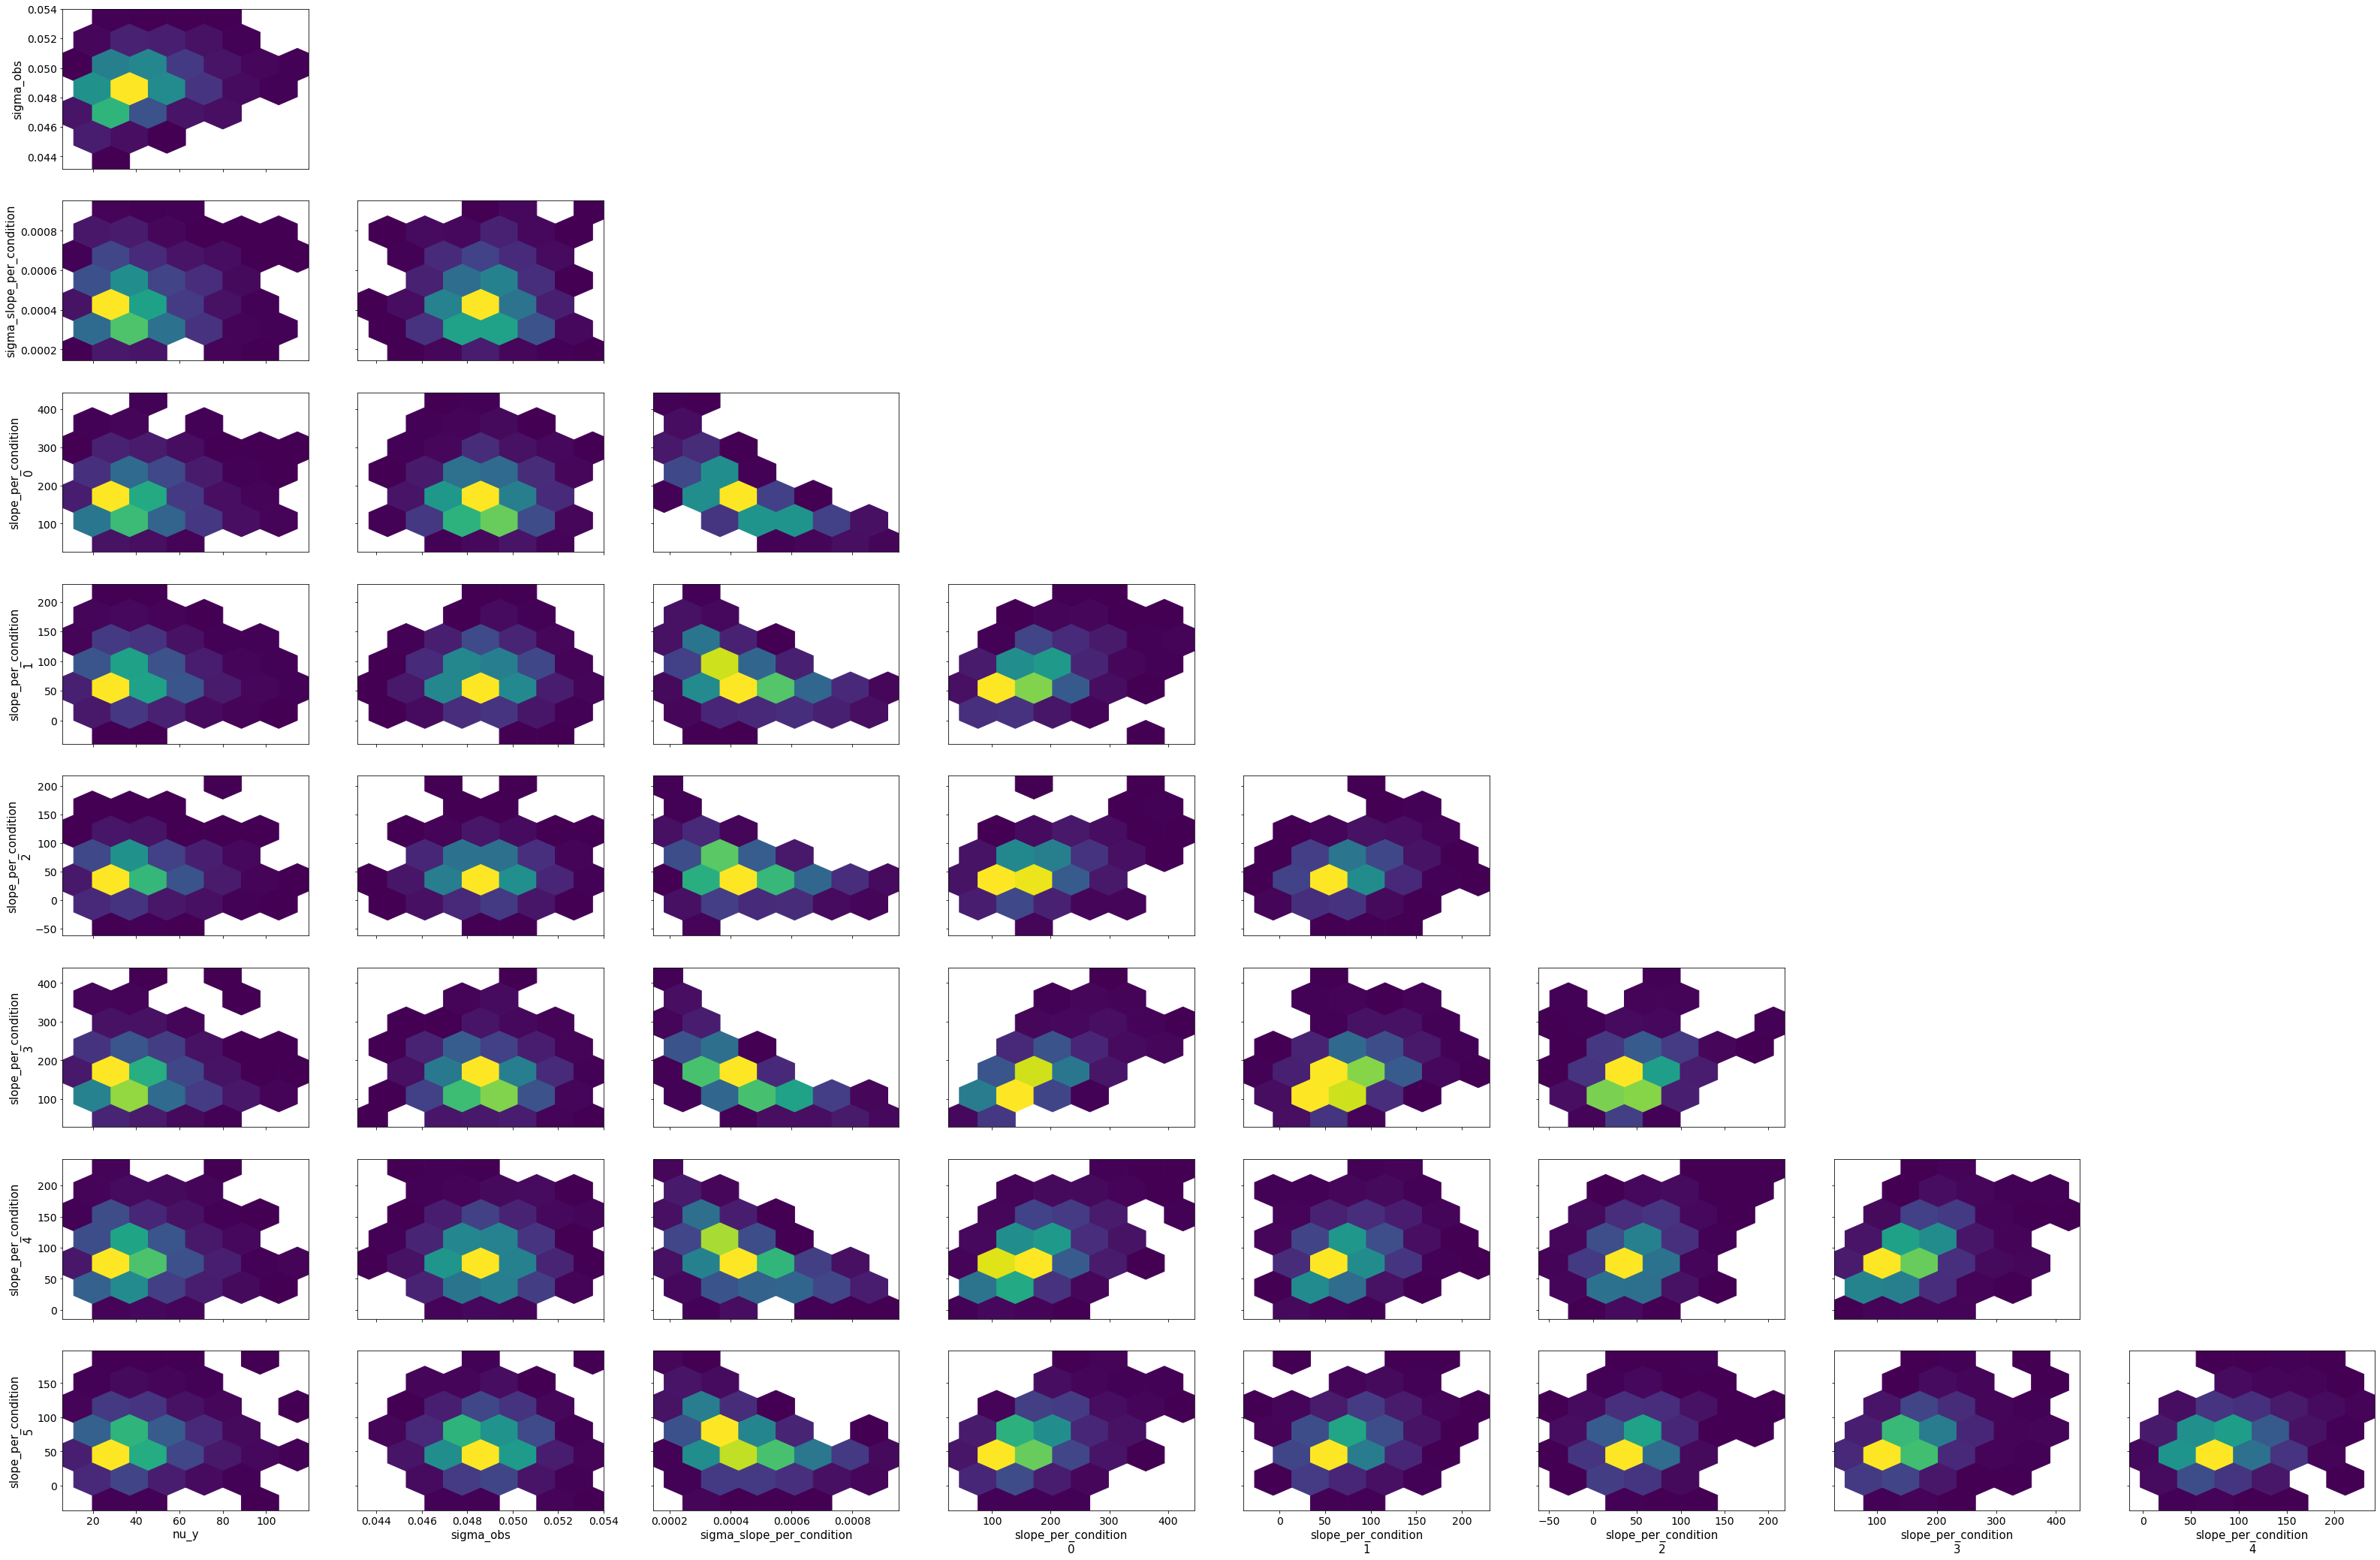

In [14]:
# Vanilla robust no interept or slope
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

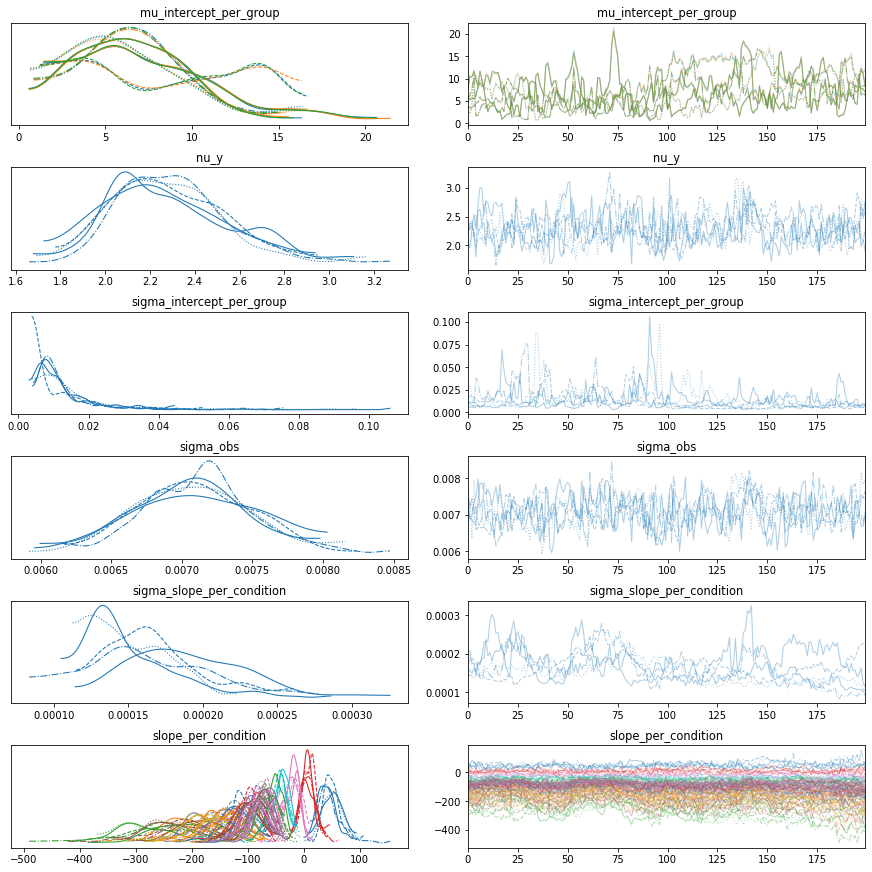

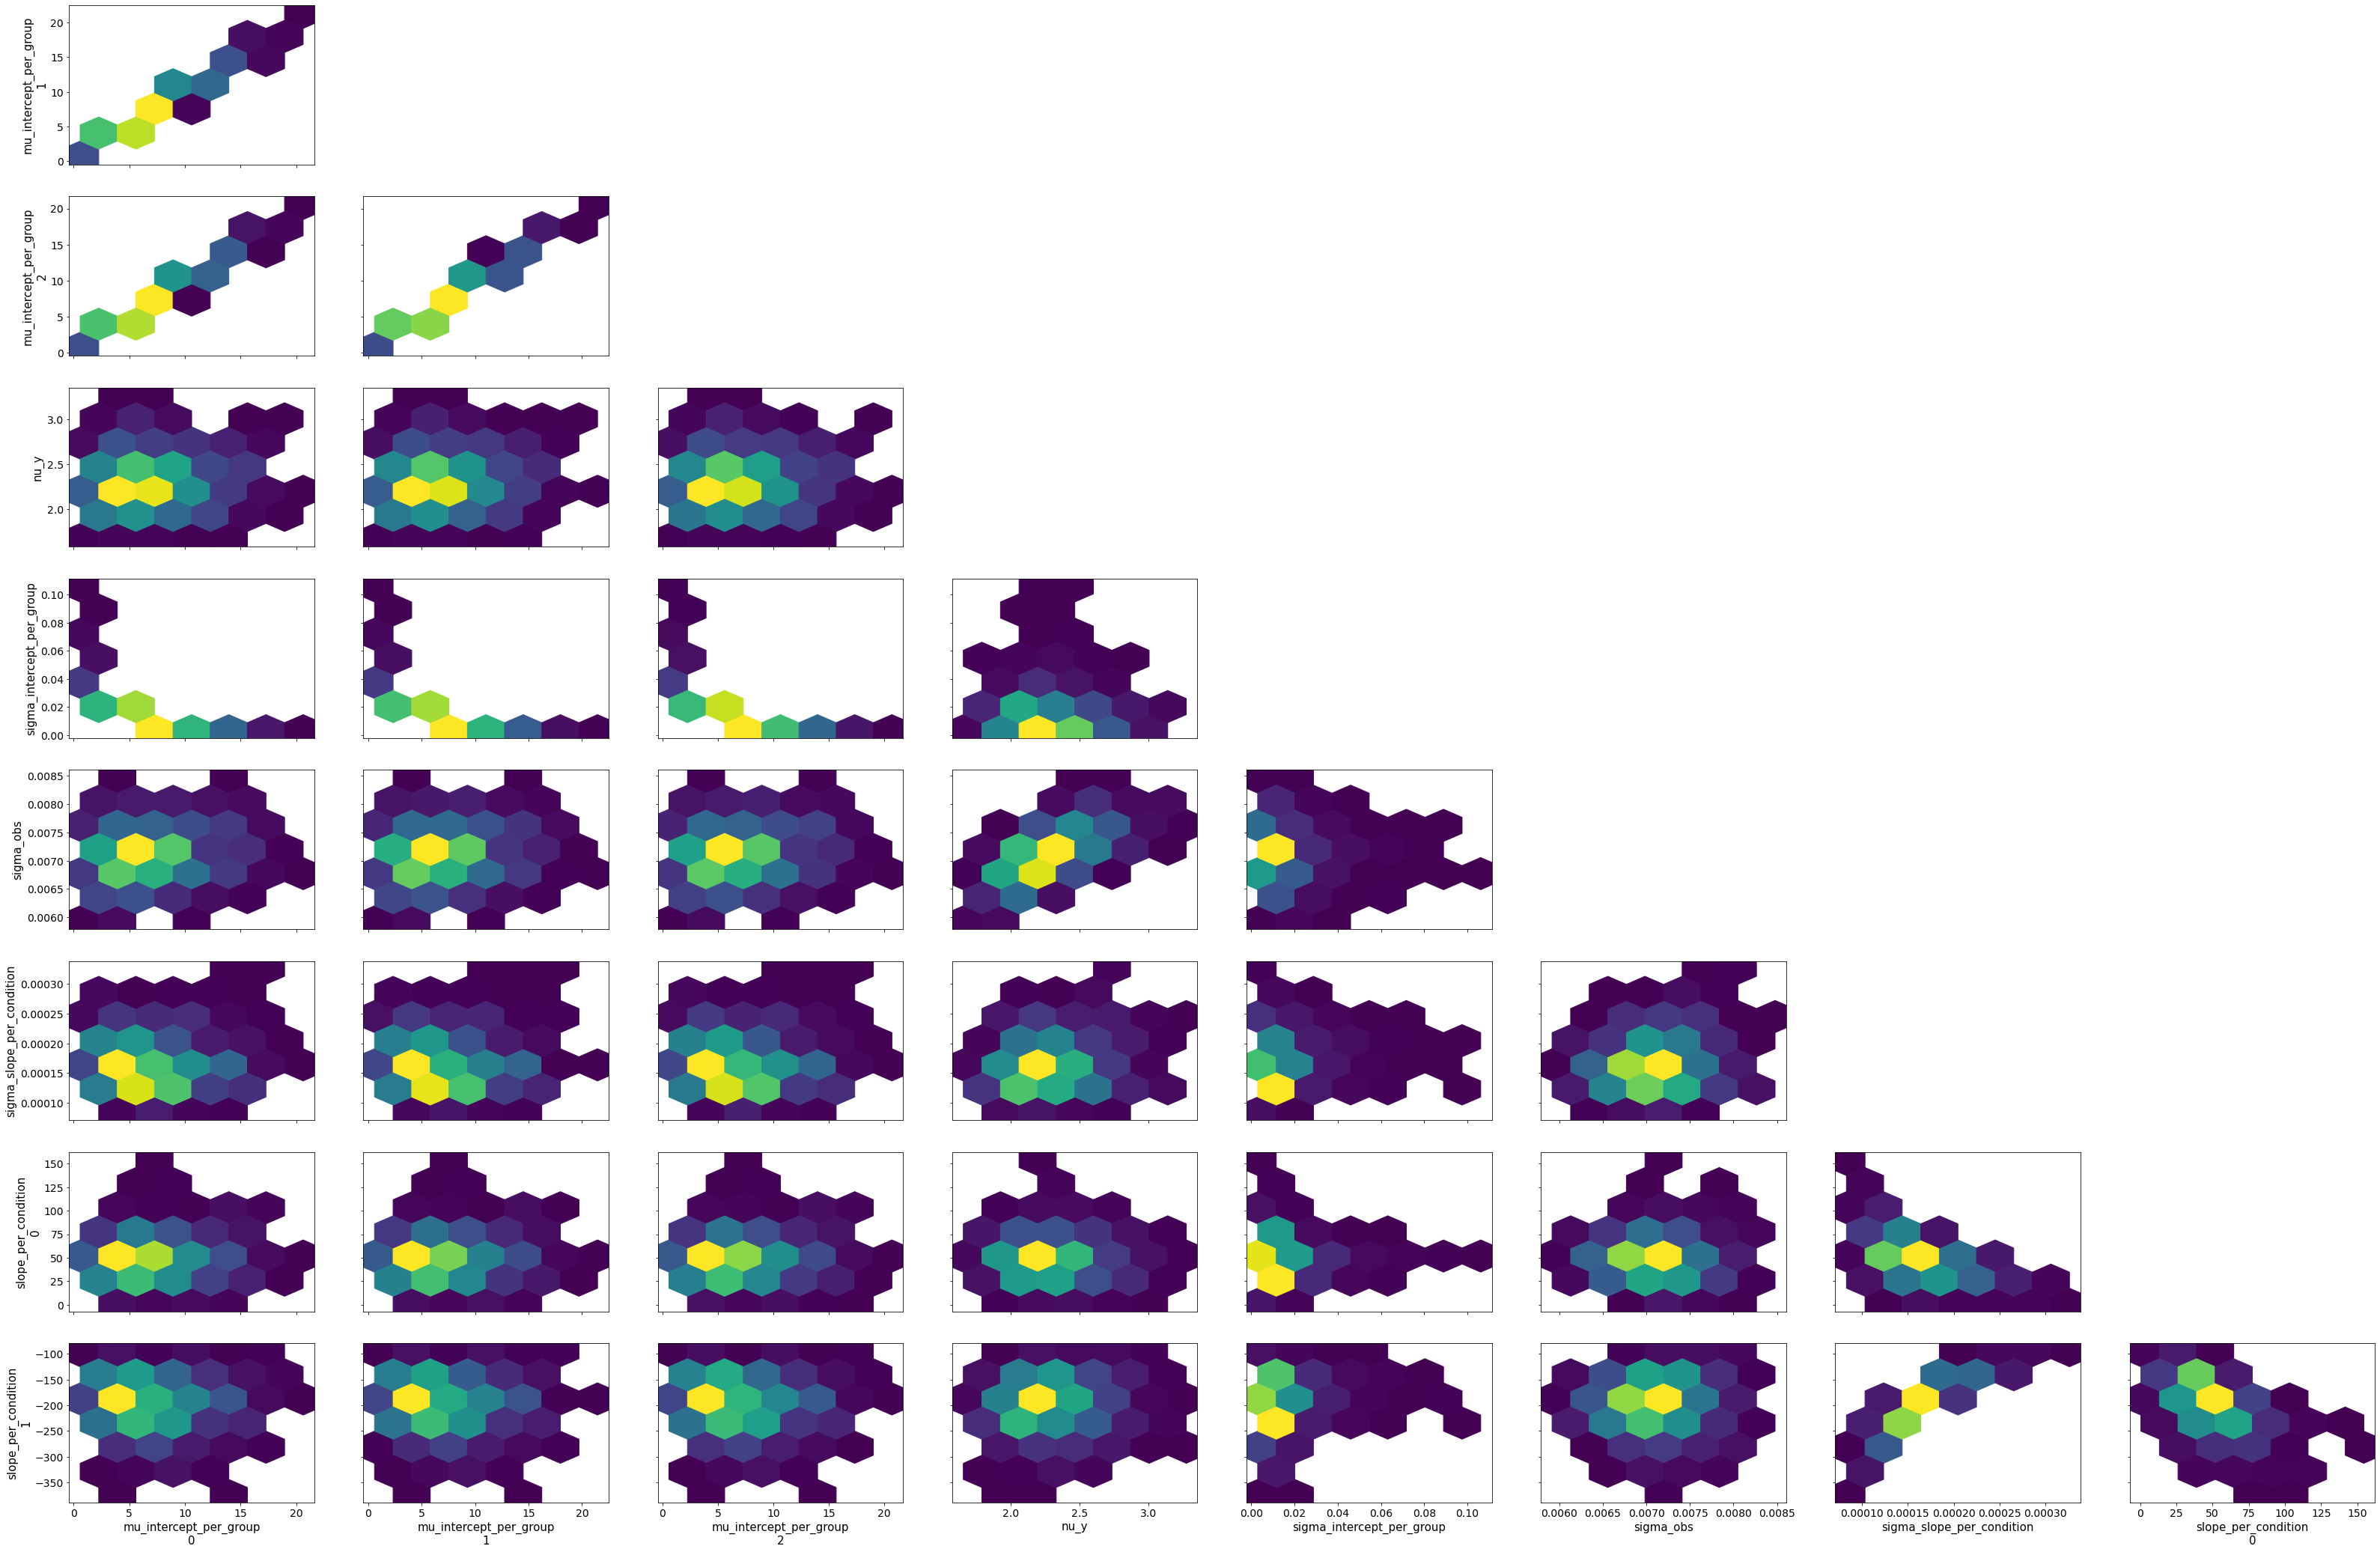

In [15]:
# Vanilla robust, intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

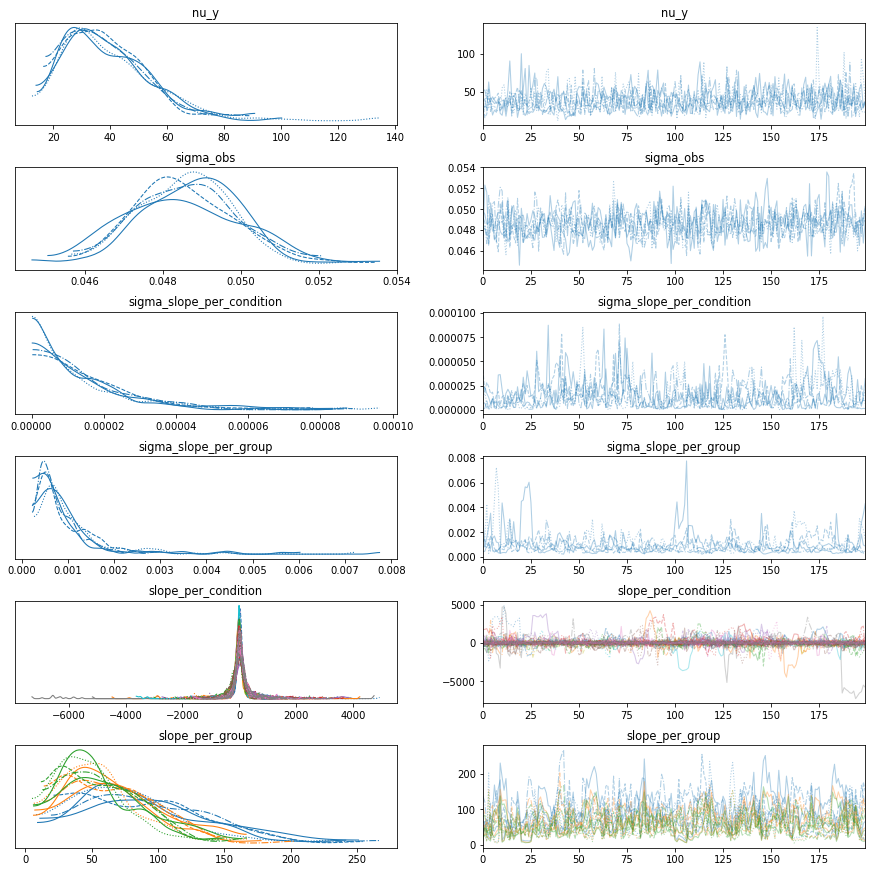

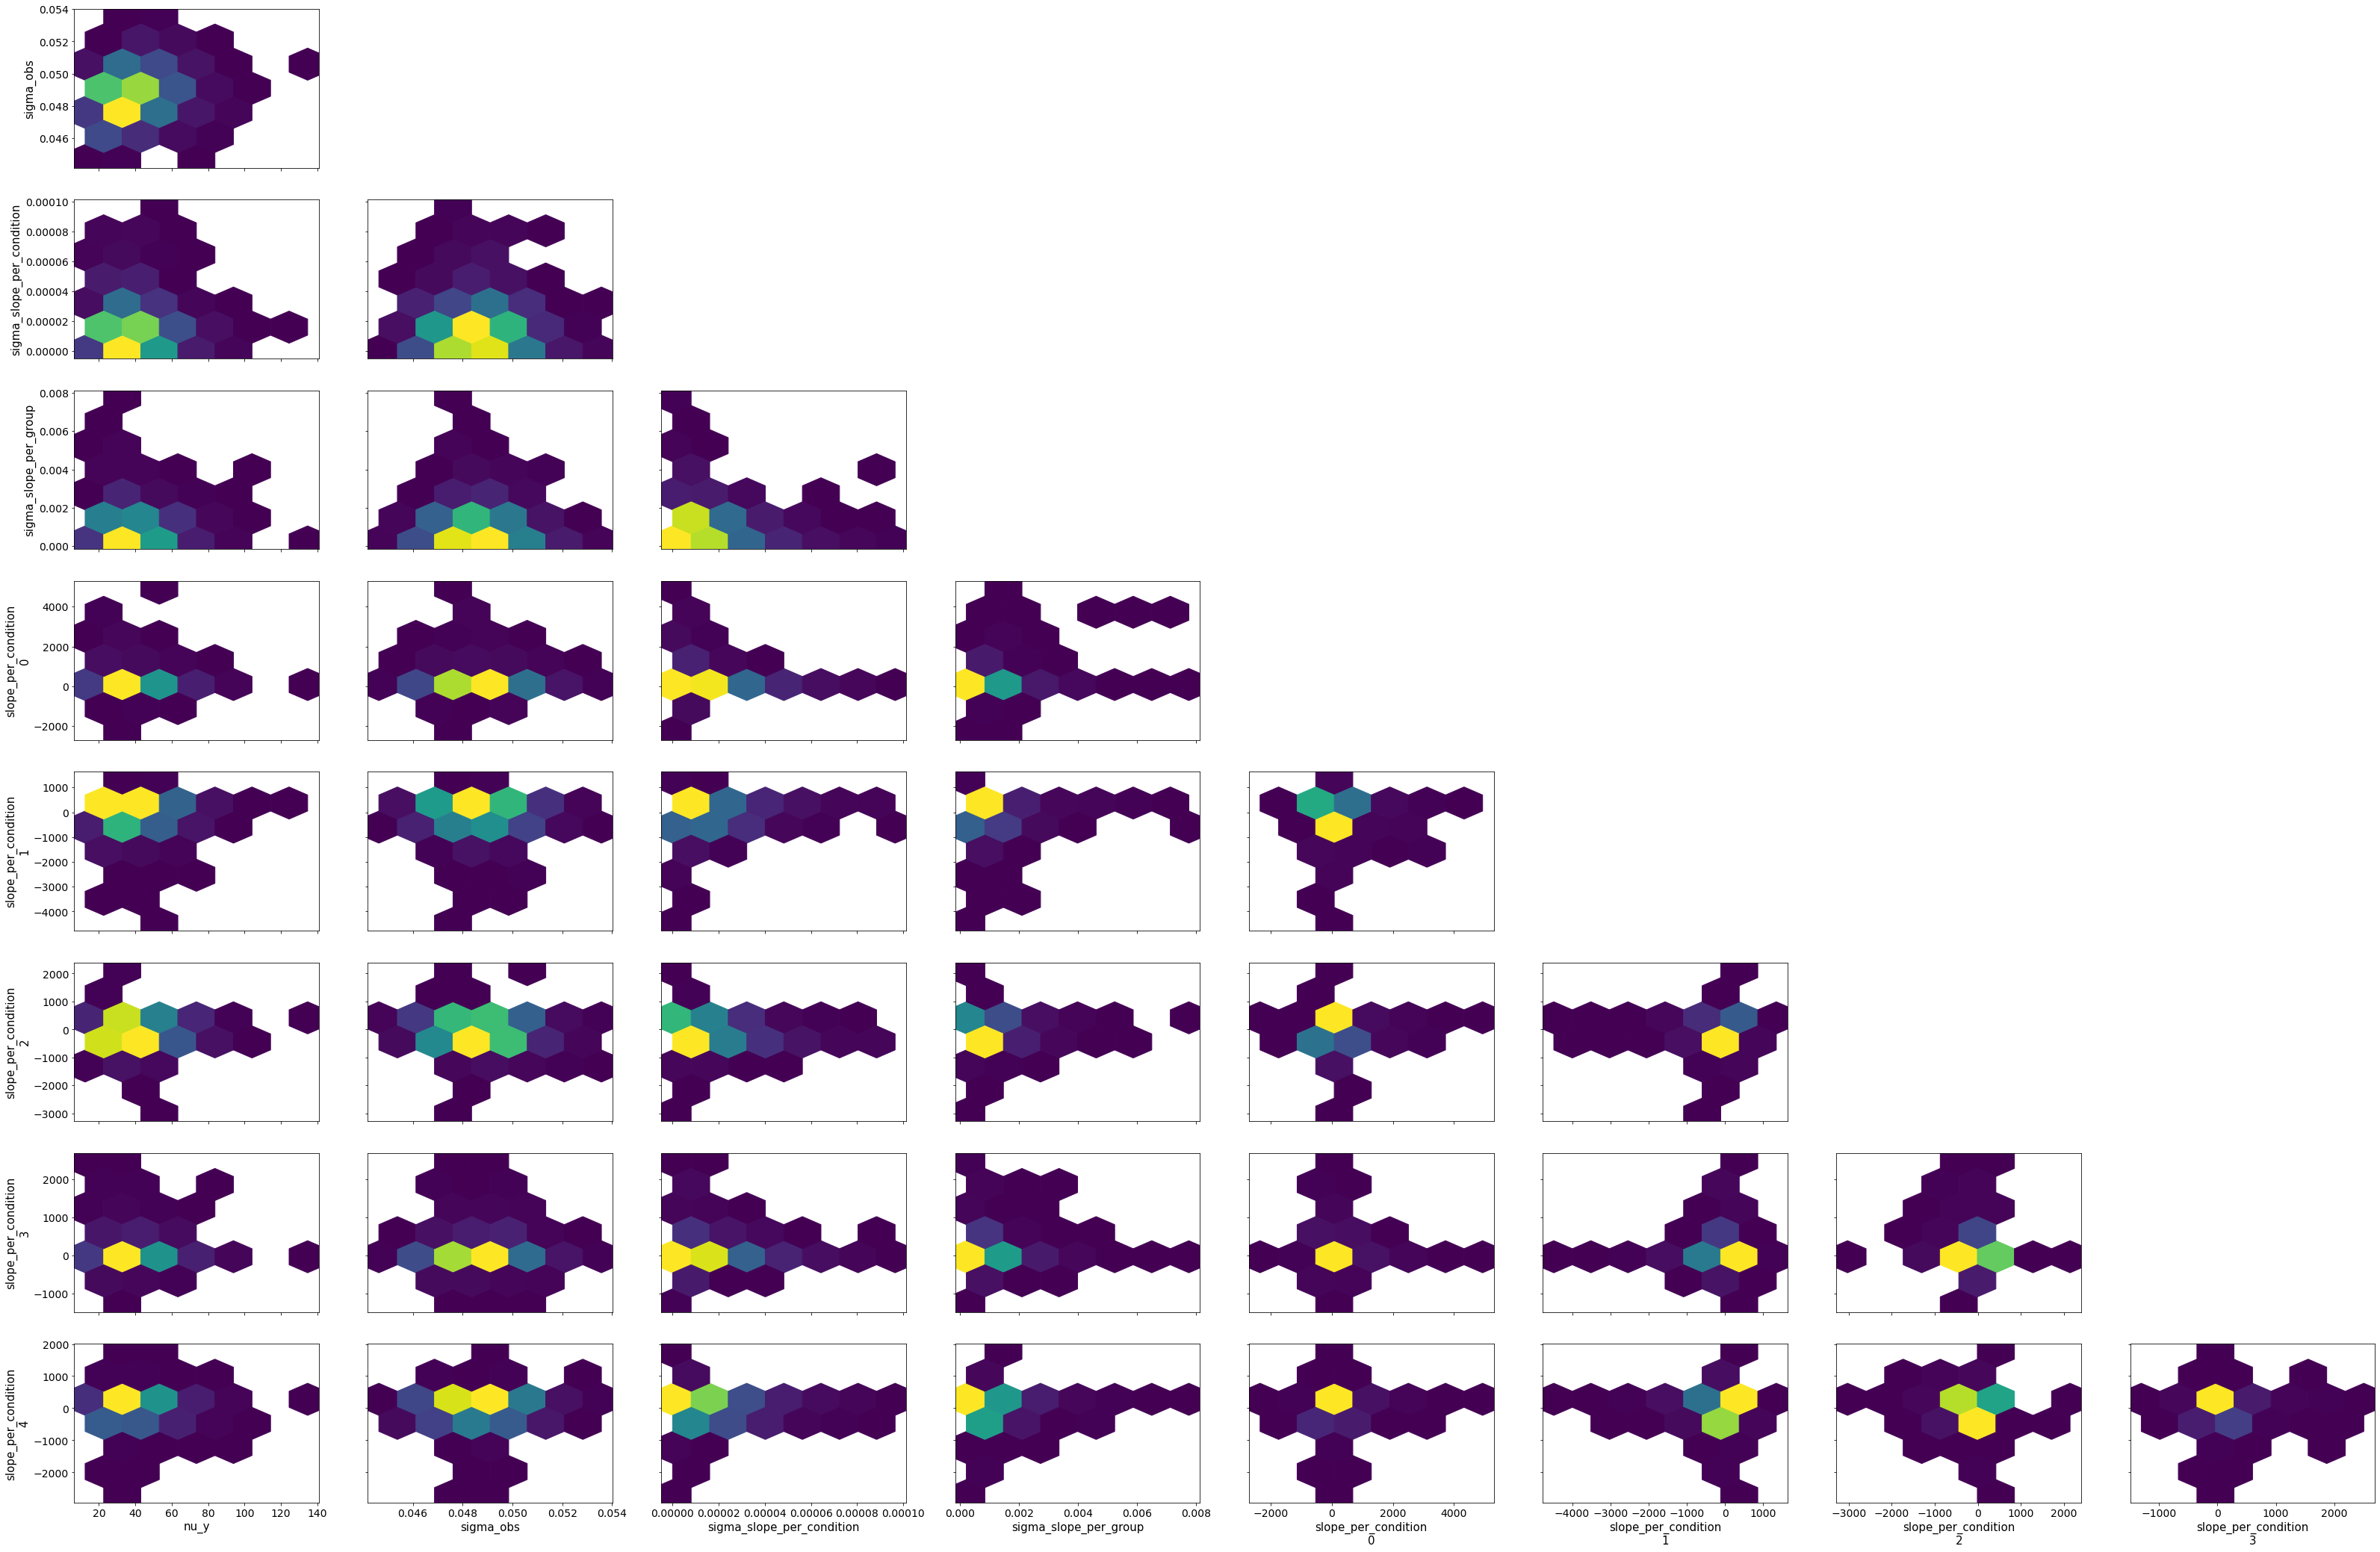

In [16]:
# Vanilla robust, slopes only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=False,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

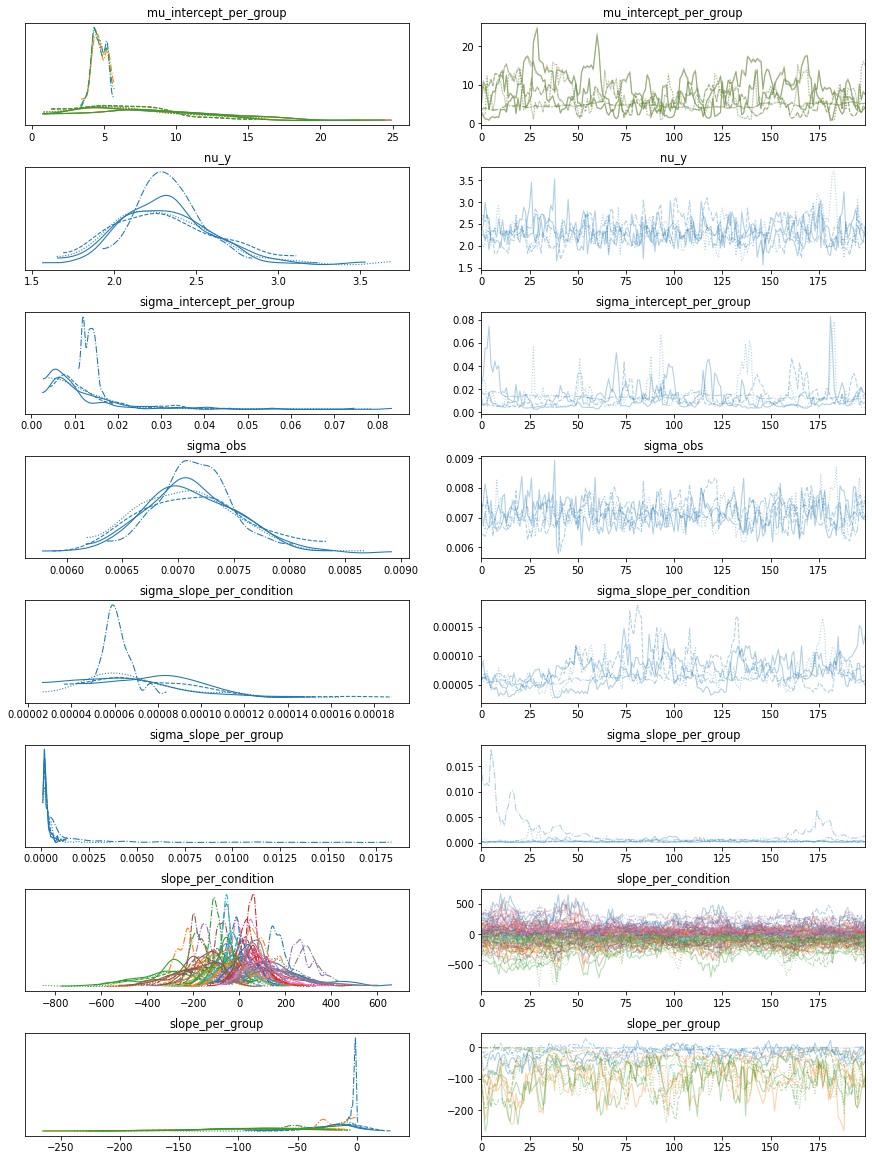

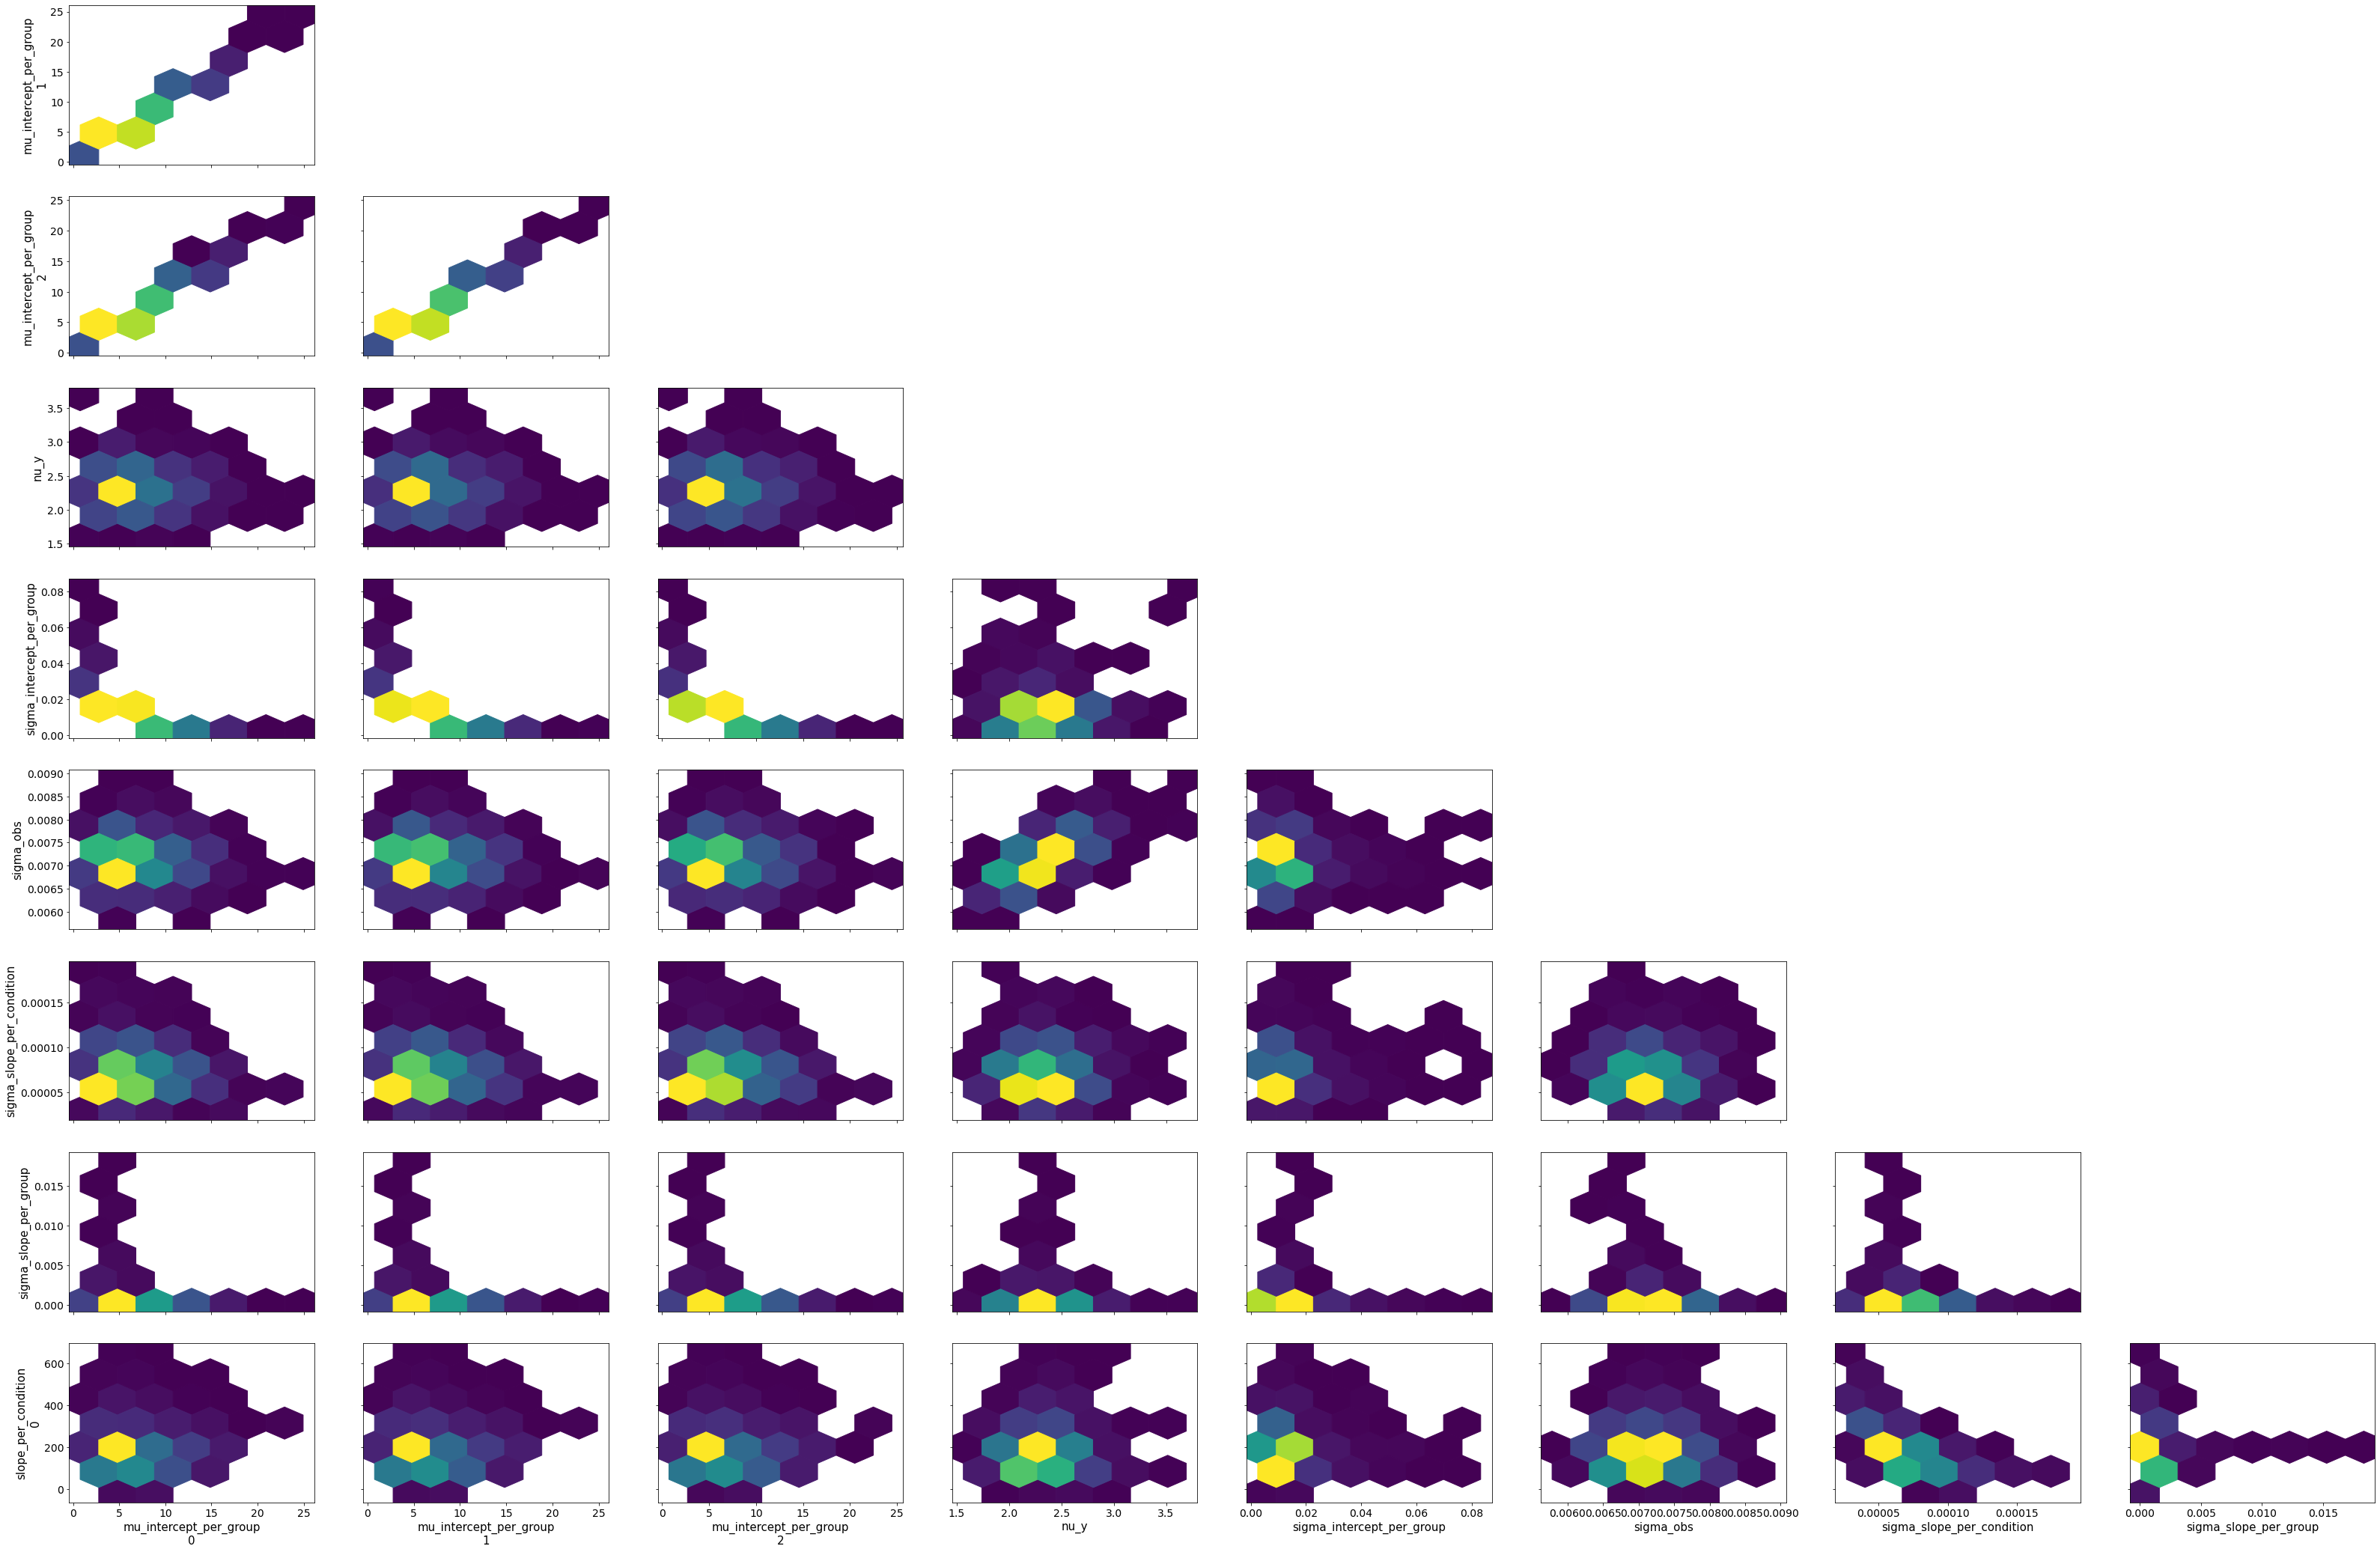

In [17]:
# Vanilla robust intercept and group
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=True,
              add_group_intercept=True,
              add_group_slope=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

n(Divergences) = 4


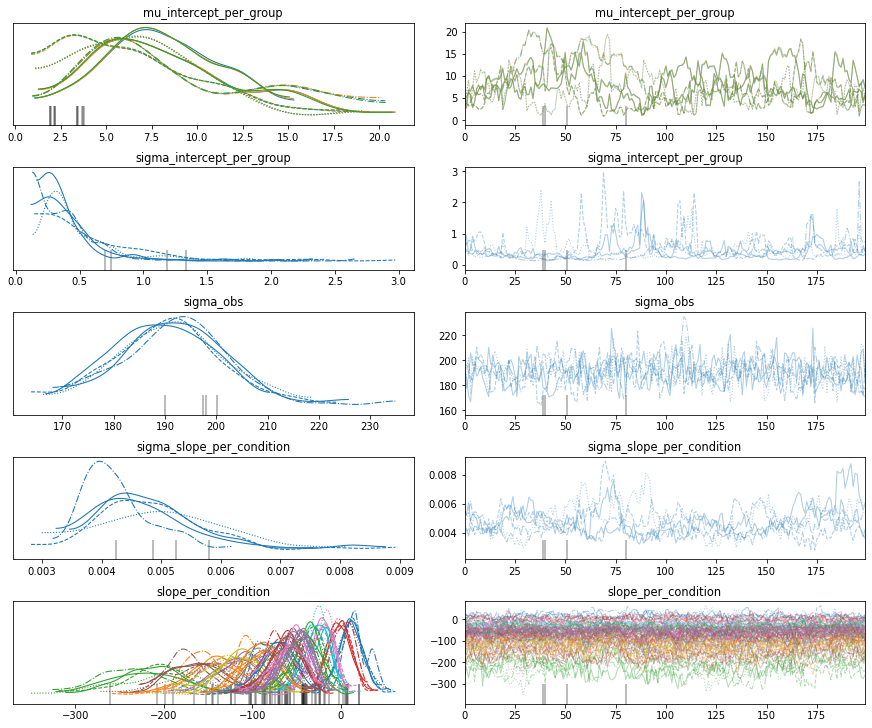

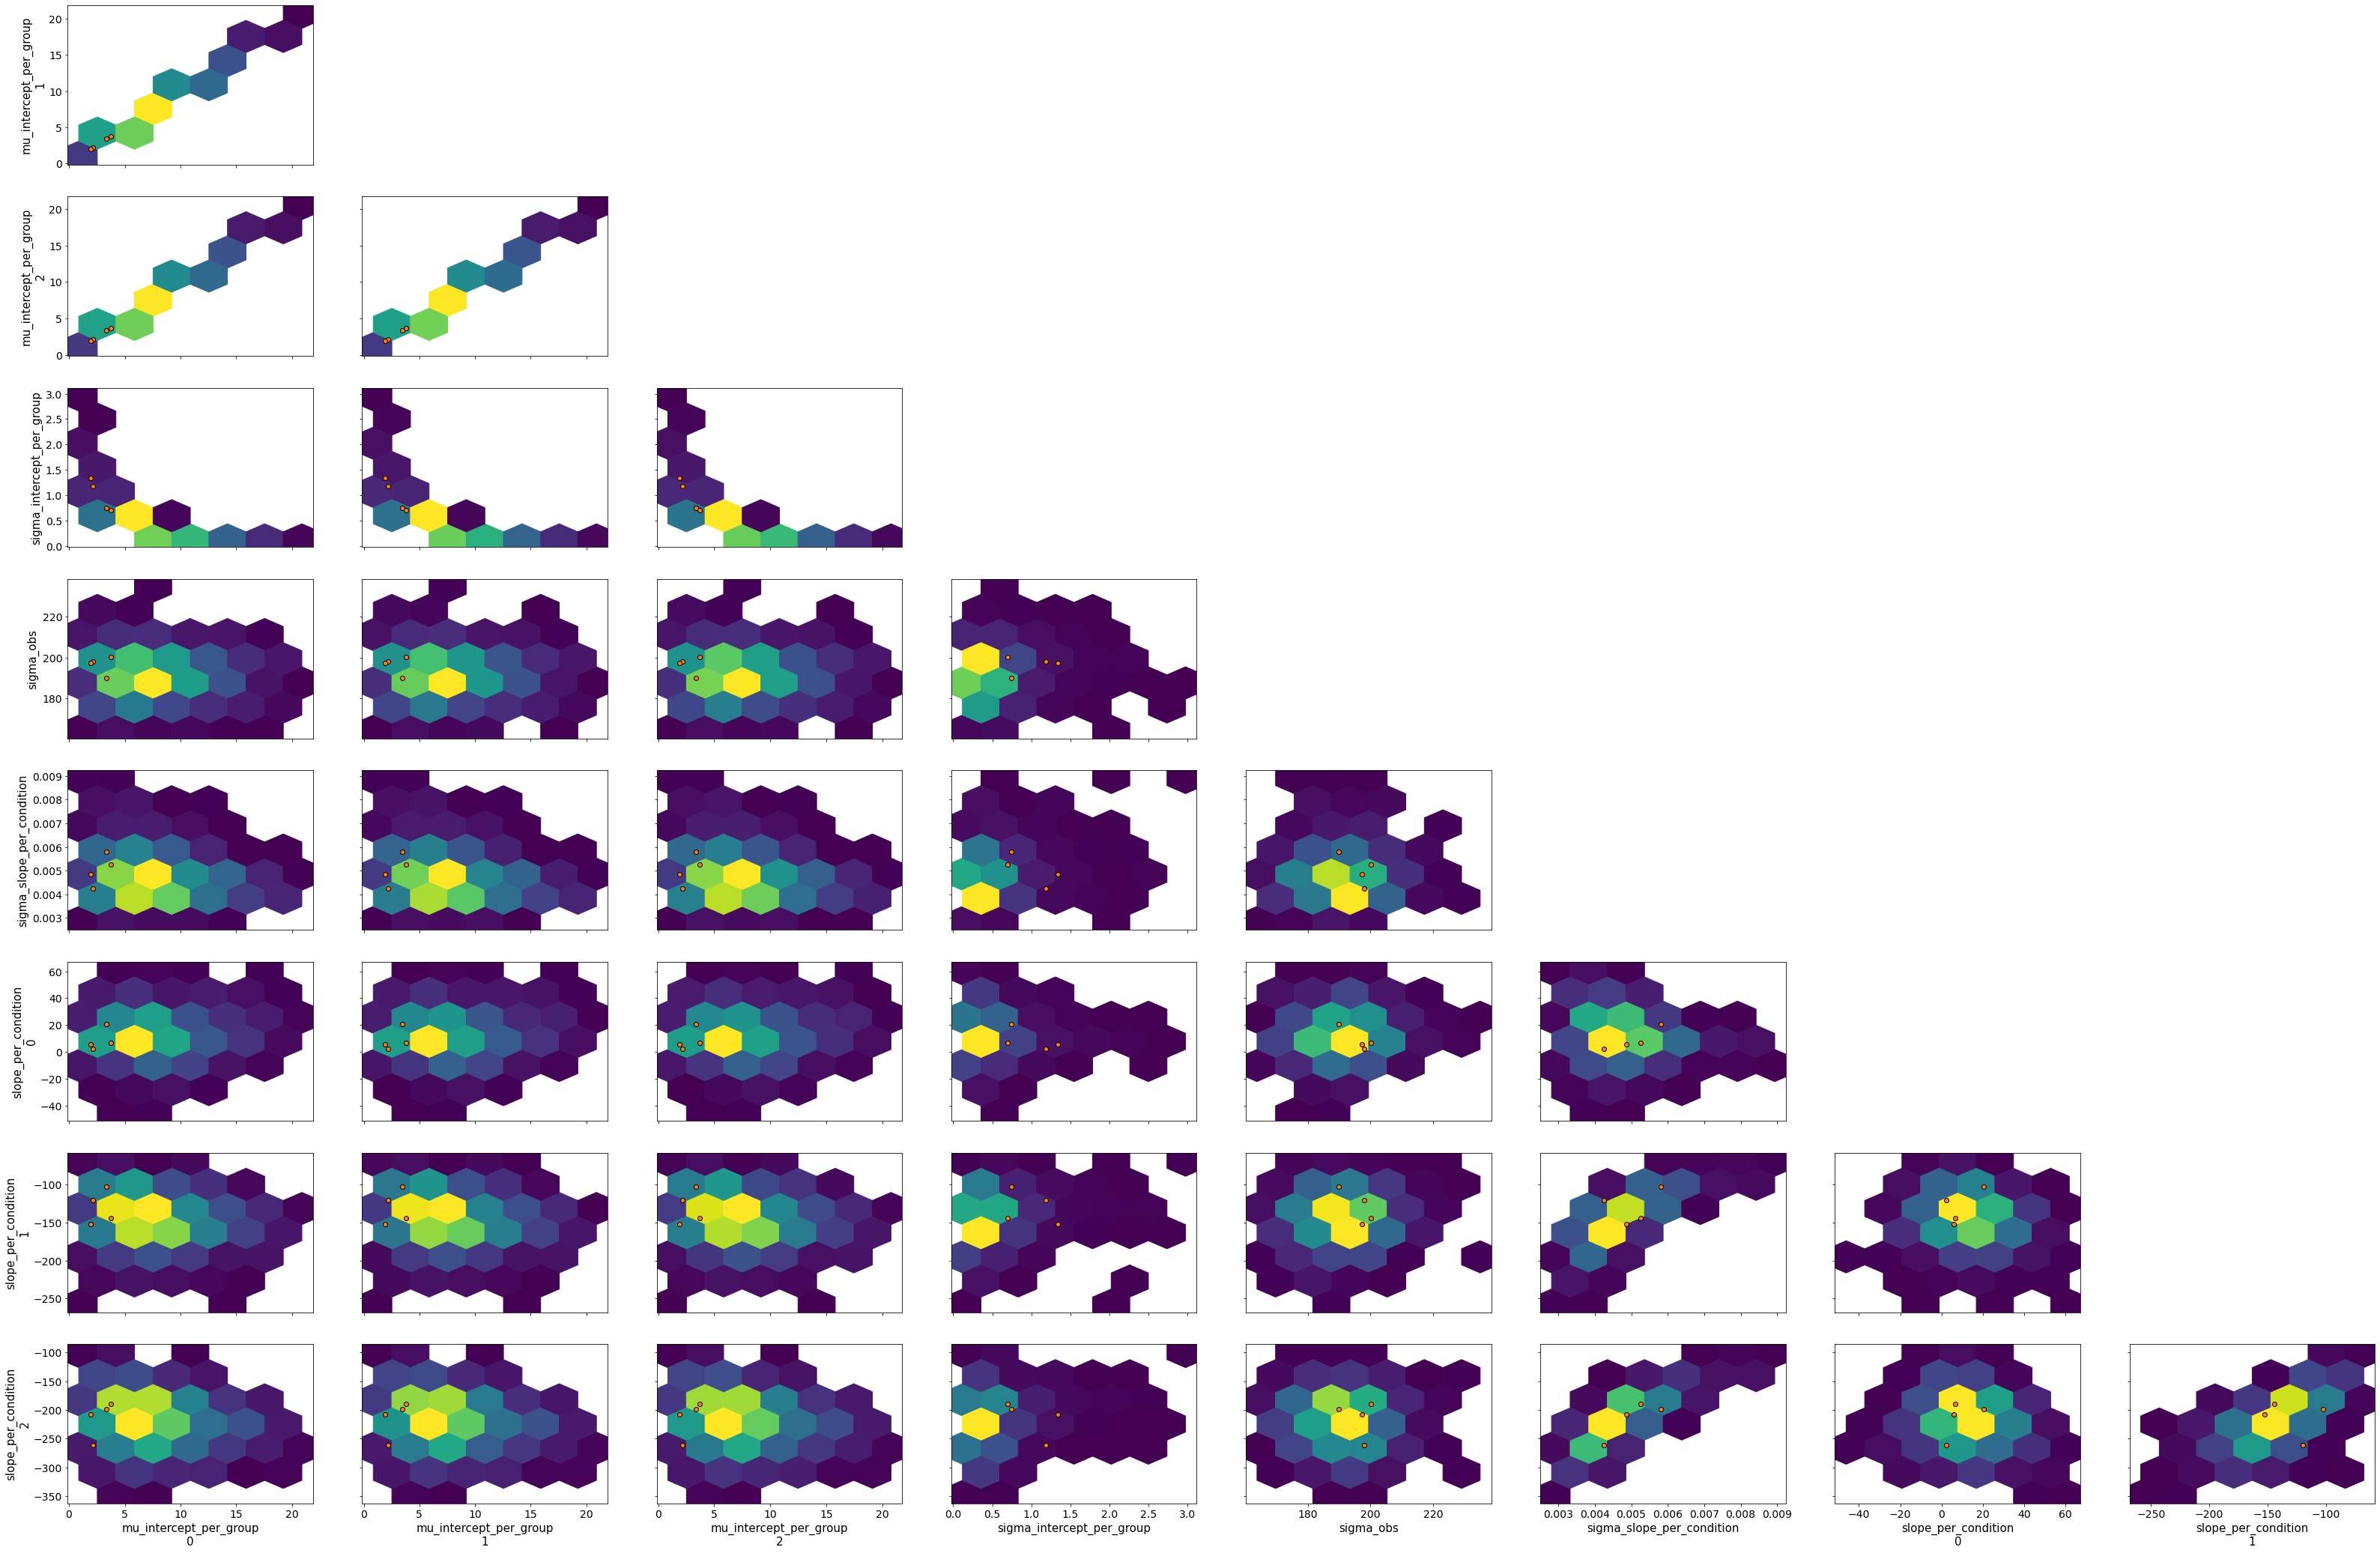

In [20]:
# Gamma GLM intercept only
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit_slopes(model=(models.model_hierarchical),
              do_make_change='subtract',
              dist_y='gamma',
              robust_slopes=False,
              add_group_intercept=True,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

group slopes+ group intercepts=>divergences

## LME fails

In [21]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=False)

Using formula isi ~ (1|mouse) + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.079    0.014    5.802  0.000   0.053   0.106
1 | mouse                  -0.007    0.007   -0.941  0.347  -0.021   0.007
stim | neuron_x_mouse__0    0.007    0.003    2.597  0.009   0.002   0.012
stim | neuron_x_mouse__1   -0.004    0.003   -1.715  0.086  -0.009   0.001
stim | neuron_x_mouse__2   -0.012    0.003   -4.695  0.000  -0.017  -0.007
stim | neuron_x_mouse__3   -0.015    0.003   -5.781  0.000  -

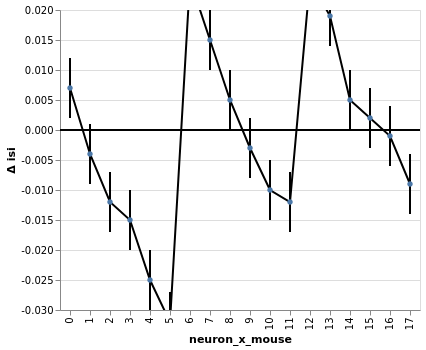

'Proper faceting will work when data addition is implemented in fit_lme()'

In [22]:
bw.chart.display()
#bw.facet(column='mouse').display()
"Proper faceting will work when data addition is implemented in fit_lme()"

In [23]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True)

Using formula isi ~ (stim|mouse)  + stim| neuron_x_mouse__0 + stim|neuron_x_mouse__1 + stim|neuron_x_mouse__2 + stim|neuron_x_mouse__3 + stim|neuron_x_mouse__4 + stim|neuron_x_mouse__5 + stim|neuron_x_mouse__6 + stim|neuron_x_mouse__7 + stim|neuron_x_mouse__8 + stim|neuron_x_mouse__9 + stim|neuron_x_mouse__10 + stim|neuron_x_mouse__11 + stim|neuron_x_mouse__12 + stim|neuron_x_mouse__13 + stim|neuron_x_mouse__14 + stim|neuron_x_mouse__15 + stim|neuron_x_mouse__16 + stim|neuron_x_mouse__17
                            Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept                   0.075    0.010    7.760  0.000   0.056   0.094
stim | mouse               -0.007    0.007   -0.941  0.347  -0.021   0.007
stim | neuron_x_mouse__0    0.005    0.003    1.396  0.163  -0.002   0.011
stim | neuron_x_mouse__1   -0.006    0.003   -1.908  0.056  -0.013   0.000
stim | neuron_x_mouse__2   -0.014    0.003   -4.192  0.000  -0.020  -0.007
stim | neuron_x_mouse__3   -0.017    0.003   -5.025  0.00

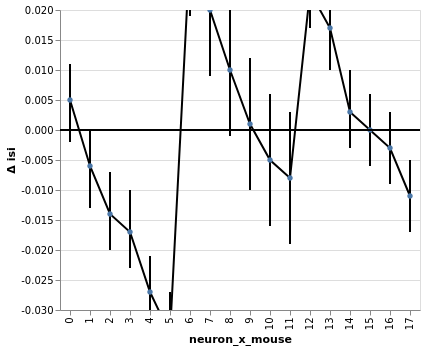

In [24]:
bw.chart

Need nested design, but get singular matrix:

In [25]:
bw = BayesWindow(df, y='isi', treatment='stim', condition=['neuron_x_mouse'], group='mouse',)
try:
    bw.fit_lme(add_data=False,add_group_intercept=True, add_group_slope=True, add_nested_group=True)
except Exception as e:
    print(e)



Using formula isi ~ (stim|mouse) + stim| neuron_x_mouse__0:mouse + stim|neuron_x_mouse__1:mouse + stim|neuron_x_mouse__2:mouse + stim|neuron_x_mouse__3:mouse + stim|neuron_x_mouse__4:mouse + stim|neuron_x_mouse__5:mouse + stim|neuron_x_mouse__6:mouse + stim|neuron_x_mouse__7:mouse + stim|neuron_x_mouse__8:mouse + stim|neuron_x_mouse__9:mouse + stim|neuron_x_mouse__10:mouse + stim|neuron_x_mouse__11:mouse + stim|neuron_x_mouse__12:mouse + stim|neuron_x_mouse__13:mouse + stim|neuron_x_mouse__14:mouse + stim|neuron_x_mouse__15:mouse + stim|neuron_x_mouse__16:mouse + stim|neuron_x_mouse__17:mouse
Singular matrix
